In [17]:
import platform
import requests
import subprocess
import os
import time
import json
import psutil
import platform
import shutil
import pynvml
import multiprocessing
import yaml
from functools import wraps
import csv
import statistics
import sys
import uuid


In [18]:
def single(cls):
    _instance = {}
    @wraps(cls)
    def _single(*args,**kargs):
        # nonlocal _instance
        if cls not in _instance :
            _instance[cls] = cls(*args,**kargs) 
        else:
            pass
        return _instance[cls]
    return _single

def run_in_sub_process(func):
    @wraps(func)
    def _sub(*arg,**krags):
        pass
    return _sub

def get_os_info() ->dict:

    device = get_gpu_list()
    try:
        print("采集系统信息")
        info = {
                "hostname":platform.node(),
                "platform":platform.platform(),
                "system":platform.system(),
                "python_version":platform.python_version(),
                "architecture":platform.architecture()[0],
                "processor":platform.processor(),
                "uname":str(platform.uname()),
                "cpu_logical_count":psutil.cpu_count(),
                "cpu_count": psutil.cpu_count(logical=False),
                "total_memory": psutil.virtual_memory().total /100000,
                "active_memory": psutil.virtual_memory().active /100000,
                "available_memory": psutil.virtual_memory().available /100000,
                "total_swap_memory":psutil.swap_memory().total /100000,
                "nvidia_gpu_info":str(device),
                "python_path":sys.executable,
                "run_path":os.getcwd()
        }
    except:
        raise BaseException("系统信息采集失败")

    return info

def watch_cpu(main_pid:int,path:str)->None:
    try:
        os.makedirs(path,mode=0o777,exist_ok=True)
        sleep_time = 5
        i =0
        count = 0
        running = is_process_running(main_pid=main_pid)
        while running:
            with open(f"{path}/cpu-{count}.log","a") as f:
                while True:
    
                    running = is_process_running(main_pid=main_pid)
                    cpu_percent = psutil.Process(pid=main_pid).cpu_percent()
                    memory = psutil.Process(pid=main_pid).memory_info().rss
                    f.write(str({"time":time.strftime('%Y-%m-%d %X', time.localtime()),"cpu_percent":cpu_percent,"memory":memory})+"\n")
                    f.flush()
                    time.sleep(sleep_time)
                    i+=1
                    if i ==(1800/sleep_time):
                        i =0
                        break
            count +=1
            continue
    except:
        raise BaseException("cpu状态监控进程启动失败")
    return
    
def save_dict_to_json(dict_value:dict , save_path:str) ->None:
    with open(save_path, 'w') as file:
        file.write(json.dumps(dict_value, indent=2))
        file.flush()
    return

def save_dict_to_yaml(dict_value: dict, save_path: str):
    with open(save_path, 'w') as file:
        file.write(yaml.dump(dict_value, allow_unicode=True))
        file.flush()
    return

def read_yaml_to_dict(yaml_path: str):
    with open(yaml_path) as file:
        dict_value = yaml.load(file.read(), Loader=yaml.FullLoader)
        return dict_value
    
def save_list_to_csv(data_list:list, output_file:str)->None:
    headers = set()
    for item in data_list:
        headers.update(item.keys())

    with open(output_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        writer.writerow(headers)
        
        for item in data_list:
            row = [item.get(key, '') for key in headers]
            writer.writerow(row)
    return

def watch_gpu(main_pid:int,path:str)->None:
    
    try:
        os.makedirs(path,mode=0o777,exist_ok=True)
        pynvml.nvmlInit()
        sleep_time =5
        device_count = pynvml.nvmlDeviceGetCount()
        running = is_process_running(main_pid=main_pid)
        i =0
        count = 0
        while running:
            with open(f"{path}/gpu-{count}.log","w") as f:
                running = is_process_running(main_pid=main_pid)
                while running:
                    running = is_process_running(main_pid=main_pid)
                    device_status =[]

                    for i in range(device_count):
                        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
                        gpu_percent = pynvml.nvmlDeviceGetUtilizationRates(handle)
                        gpu_memory = pynvml.nvmlDeviceGetMemoryInfo(handle)
                        status = {"time":time.strftime('%Y-%m-%d %X', time.localtime()),"gpu_percent":gpu_percent.gpu,"gpu_memory":gpu_memory.used}
                        device_status.append(status)
                    f.write(str(device_status)+"\n")
                    f.flush()
                    time.sleep(sleep_time)
                    i+=1
                    if i == 1800/sleep_time:
                        i = 0
                        break
                count+=1
                continue
    except:
        raise BaseException("gpu监控进程启动失败")

def is_process_running(main_pid:int) ->bool:
    try:
        ps = psutil.Process(pid=main_pid)
        return ps.is_running
    except:
        return False
    



def save_conda_info(path:str) ->bool:
    try:
        result = subprocess.run(['conda', 'list'], capture_output=True, text=True)
        output = result.stdout
        with open(f"{path}/conda.info","a") as file:
                file.write(output)
                file.flush()
        return True
    except:
        return False

def get_gpu_list() ->list:
    device_list =[]
    try:
        print("获取Nvidia显卡信息 \n")
        pynvml.nvmlInit()
        device_count=pynvml.nvmlDeviceGetCount()

        for i in range(device_count):
            handle = pynvml.nvmlDeviceGetHandleByIndex(i)
            device_list.append(str(pynvml.nvmlDeviceGetName(handle)))

    except:
        print("未获取到Nvidia显卡信息 \n")

def has_multiple_keys(dictionary:dict, *keys):
    return set(keys).issubset(dictionary.keys())



def get_init_trainning_status()->dict:
    return {"epoch":[],"next_start_at":0,"count":0}

def get_process_pid():
    return os.getpid()

def get_all_recorded_element(data)->list:
    elemet_list = []
    for d in data :
        elemet_list.extend(list(d.keys()))
    result = list(set(elemet_list))
    print(result)
    return result
    
def quick_analysis(status:list) ->dict:
    result = {}
    element_list = get_all_recorded_element(status)
    for e in element_list:
        result[e] = []
        for s in status:
            if e in s.keys():
                result[e].append(s[e])
        result[e+"_max"] = max(result[e])
        result[e+"_min"] = min(result[e])
        result[e+"_viriance"]=statistics.variance(result[e])
        result[e+"_stdev"]=statistics.variance(result[e])
        result[e+"_avg"] = statistics.mean(result[e])
    
    return result
                
                                           
    
    
    
    


In [19]:
def NewLogger(conf:dict,info:dict):
    log = Logger(config=conf)
    log.Start(info=info)
    return log
        

@single
class Logger():
    def __init__(self,config:dict,host="127.0.0.1") -> None:

        if not has_multiple_keys(config, 'access_token', 'project',"discription"):
            raise BaseException("缺失启动信息,请补充config参数")
        
        config["experiment"] = str(uuid.uuid4())
        
        self.__config = config
        print("验证代理客户端状态 \n")
        self.__verify_my_client()
        self.__save_config()

        self.__pid = get_process_pid()

        self.__api_load_save_path = f"http://{host}:5560/ml_client/client/loadSavePath"
        self.__api_notice_experiment = f"http://{host}:5560/ml_client/client/noticeExperiment"
        self.__api_notice_run = f"http://{host}:5560/ml_client/client/noticeRun"
        

        self.__trainning_status  = get_init_trainning_status()
        self.__watcher()

        
    def __verify_my_client(self) ->None:
        try:
            # resp  = requests.get(utl=self.__loadSavePath)
            print("开发阶段跳过校验 \n")
        except:
            raise BaseException("用户校验失败，请检查客户端是否启动\n")
        else:
            print("代理客户端验证通过 \n")
            self.__login = True
            self.__location = f".location/{self.__config['experiment']}"
            self.__savedir = f"{self.__location}/code"
            self.__codedir = "src"
            self.__srcignore = "datasets"
            i = 0
            self.__epochid = f"run-{i}"
            
            while os.path.exists(f"{self.__location}/run-{i}"):
                i+=1
                self.__epochid = f"run-{i}"

        os.makedirs(f"{self.__location}",mode=0o777,exist_ok=True)
        return

    def __watcher(self) ->None:
        cpu_dir =f"{self.__location}/watcher/cpu"
        self.__watcher_cpu = multiprocessing.Process(target=watch_cpu ,daemon=True, args=(self.__pid,cpu_dir))
        self.__watcher_cpu.start()

        gpu_dir =f"{self.__location}/watcher/gpu"
        self.__watcher_gpu = multiprocessing.Process(target=watch_gpu,daemon=True, args=(self.__pid,gpu_dir))
        self.__watcher_gpu.start()

        return

    def Start(self,info:dict) ->None:

        if not save_conda_info(self.__location):
            print("未采集到conda信息")

        try:
            now = time.strftime("%Y-%m-%d %X", time.localtime())
            print(f"运行开始时间：{now} \n")
            self.__trainning_status["start_at"] = now

            self.__osinfo = get_os_info()
            
            os_info_json_path =f"{self.__location}/os_info.json"
            os_info_yaml_path =f"{self.__location}/os_info.yaml"

            save_dict_to_json(self.__osinfo,os_info_json_path)
            save_dict_to_yaml(self.__osinfo,os_info_yaml_path)
            
            super_arg_json_path = self.__location+"/super_arg.json"
            super_arg_yaml_path = self.__location+"/super_arg.yaml"

            save_dict_to_json(info,super_arg_json_path)
            save_dict_to_yaml(info,super_arg_yaml_path)
            
            with open(f"{self.__location}/start.tag",mode="w") as f:
                f.write(f"{now} | {self.__epochid} \n")
                f.flush()
                
            # self.__stdout = sys.stdout
            # self.__stderr = sys.stderr

            # self.__console = open(f"{self.__location}/console.log","w")
        
            # sys.stdout = self.__console
            # sys.stderr = self.__console
            if os.path.exists("./requirements.txt"):
                shutil.copy("./requirements.txt",f"{self.__location}")
            
        except:
            raise BaseException("日志实例启动失败\n")

        else:
            pass
        return
        
        
    def SaveFile(self,path_list:list) ->None:
        os.makedirs(f"{self.__location}/{self.__epochid}/files",exist_ok=True)
        for path in path_list:
            if os.path.exists(path):
                shutil.copy(path,f"{self.__location}/{self.__epochid}/files")
        return
    
        
    def EpochStart(self) ->None:
        now = time.strftime("%Y-%m-%d %X", time.localtime())
        
        i=0
        while os.path.exists(f"{self.__location}/run-{i}"):
            i+=1
            self.__epochid = f"run-{i}"
            
        
        os.makedirs(f"{self.__location}/{self.__epochid}",exist_ok=True)

        with open(f"{self.__location}/{self.__epochid}/start.tag",mode="w") as f:
            f.write(f"{now} | {self.__epochid} \n")
            f.flush()

        #通知客户端开始
        
        return

    def EpochLog(self,info:dict) ->None:
        
        self.__trainning_status["count"] += 1

        try:
            this_epoch = info
            self.__trainning_status["epoch"].append(this_epoch)
                
            #通知客户端结束
        except:
            raise BaseException("Epoch日志采集失败")
        
        return
    
    def EpochEnd(self) ->None:
        
        result_path =f"{self.__location}/{self.__epochid}/results.json"
    
        save_dict_to_json(self.__trainning_status["epoch"][self.__trainning_status["next_start_at"]:self.__trainning_status["count"]],result_path)
        
        self.__trainning_status["next_start_at"] = self.__trainning_status["count"]

        return
    
    
    def End(self) ->None:
        now = time.strftime("%Y-%m-%d %X", time.localtime())
        print(f"运行结束时间：{now}\n")
        self.__trainning_status["end_at"] = now
        with open(f"{self.__location}/"+"/finish.tag",mode="a") as f:
            f.write(f"{now} | {self.__epochid} \n")
            f.flush()
        with open(f"{self.__location}/finish.tag",mode="w") as f:
            f.write(f"{now} | {self.__epochid} \n")
            f.flush()
        self.__save_code()
        self.__watcher_cpu.kill()
        self.__watcher_gpu.kill()
        
        result_csv_path = f"{self.__location}/result.csv"
        save_list_to_csv(self.__trainning_status["epoch"],result_csv_path)
        dict = quick_analysis(status=self.__trainning_status["epoch"])
        analysis_json_path = f"{self.__location}/analysis.json"
        analysis_yaml_path = f"{self.__location}/analysis.yaml"
        save_dict_to_json(dict,analysis_json_path)
        save_dict_to_yaml(dict,analysis_yaml_path)
        
        return
    
    def __save_config(self) ->None:
        try:
            config_path_json = self.__location +"/"+"config.json"
            save_dict_to_json(self.__config,config_path_json)
            config_path_yaml = self.__location +"/"+"config.yaml"
            save_dict_to_yaml(self.__config,config_path_yaml)
        except:
            raise BaseException("保存配置信息失败 \n")
        return

    def __save_code(self,path=["datasets"])->None:
        ignore_path = [*path]
        try:
            if os.path.exists(".path_ignore"):
                with open(".path_ignore") as f:
                    line =  f.readline()
                    while line:
                        ignore_path.append(line.strip())
                        line = f.readline()
            shutil.copytree(src=self.__codedir,dst=self.__savedir,dirs_exist_ok=True,ignore=shutil.ignore_patterns(*ignore_path))
        except:
            raise BaseException("备份代码失败 \n")
        else:
            return


    #废弃方法，请从Start()接口输入超参数    
    def SuperArg(self,info:dict)->None:
        path =self.__location+"/"+self.__epochid+"/super_arg.json"
        with open(path,mode="w") as f:
            f.write(f"{json.dumps(info)}")
        return

    #ShowStatus ：仅开发过程使用
    def ShowStatus(self) -> str:
        return json.dumps(self.__trainning_status["epoch"],indent=2)

验证代理客户端状态 

开发阶段跳过校验 

代理客户端验证通过 

运行开始时间：2023-10-23 21:04:43 

获取Nvidia显卡信息 

采集系统信息
torch.Size([60000, 28, 28])
torch.Size([60000])


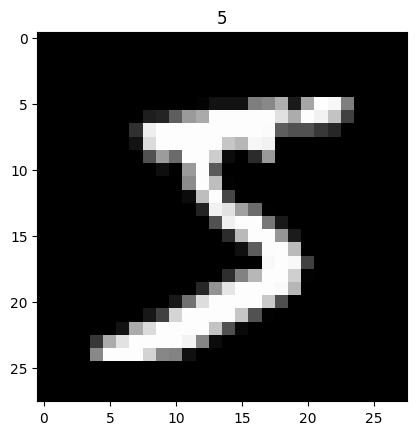

now epoch :   0    |  loss : 2.3011       |   accuracy :    0.1915
now epoch :   0    |  loss : 0.8289       |   accuracy :    0.809
now epoch :   0    |  loss : 0.2486       |   accuracy :    0.8835
now epoch :   0    |  loss : 0.3018       |   accuracy :    0.911
now epoch :   0    |  loss : 0.1036       |   accuracy :    0.9285
now epoch :   0    |  loss : 0.2409       |   accuracy :    0.942
now epoch :   0    |  loss : 0.1481       |   accuracy :    0.952
now epoch :   0    |  loss : 0.0344       |   accuracy :    0.957
now epoch :   0    |  loss : 0.0581       |   accuracy :    0.9615
now epoch :   0    |  loss : 0.0972       |   accuracy :    0.9615
now epoch :   0    |  loss : 0.1388       |   accuracy :    0.9675
now epoch :   0    |  loss : 0.0157       |   accuracy :    0.974
now epoch :   0    |  loss : 0.1204       |   accuracy :    0.965
now epoch :   0    |  loss : 0.0776       |   accuracy :    0.9705
now epoch :   0    |  loss : 0.0210       |   accuracy :    0.966
now

In [20]:
# @Time : 2020/6/6 13:23 
# @Author : kingback
# @File : cnn_test.py 
# @Software: PyCharm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

log = NewLogger(

    conf={
    'access_token':"access_token",
    'project':"project", 
    "discription":"discription"},

    info={
    "learnning_rate":0.002,
    "epoch":30,
    "batch_size":8
    }
)

#Hyper prameters
EPOCH=10
BATCH_SIZE=50
LR=0.001
DOWNLOAD_MNIST=False

train_data=torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),    #将下载的文件转换成pytorch认识的tensor类型，且将图片的数值大小从（0-255）归一化到（0-1）
    download=DOWNLOAD_MNIST
)

#画一个图片显示出来
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0].numpy(),cmap='gray')
plt.title('%i'%train_data.targets[0])
plt.show()

train_loader=Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data=torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
)
with torch.no_grad():
    test_x=Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255   #只取前两千个数据吧，差不多已经够用了，然后将其归一化。
    test_y=test_data.targets[:2000]

'''开始建立CNN网络'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        '''
        一般来说，卷积网络包括以下内容：
        1.卷积层
        2.神经网络
        3.池化层
        '''
        self.conv1=nn.Sequential(
            nn.Conv2d(              #--> (1,28,28)
                in_channels=1,      #传入的图片是几层的，灰色为1层，RGB为三层
                out_channels=16,    #输出的图片是几层
                kernel_size=5,      #代表扫描的区域点为5*5
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=2
            ),    # 2d代表二维卷积           --> (16,28,28)
            nn.ReLU(),              #非线性激活层
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值          --> (16,14,14)
        )

        self.conv2=nn.Sequential(
            nn.Conv2d(              #       --> (16,14,14)
                in_channels=16,     #这里的输入是上层的输出为16层
                out_channels=32,    #在这里我们需要将其输出为32层
                kernel_size=5,      #代表扫描的区域点为5*5
                stride=1,           #就是每隔多少步跳一下
                padding=2,          #边框补全，其计算公式=（kernel_size-1）/2=(5-1)/2=
            ),                      #   --> (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    #设定这里的扫描区域为2*2，且取出该2*2中的最大值     --> (32,7,7)，这里是三维数据
        )

        self.out=nn.Linear(32*7*7,10)       #注意一下这里的数据是二维的数据

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)     #（batch,32,7,7）
        #然后接下来进行一下扩展展平的操作，将三维数据转为二维的数据
        x=x.view(x.size(0),-1)    #(batch ,32 * 7 * 7)
        output=self.out(x)
        return output
        
cnn=CNN()
# print(cnn)

# 添加优化方法
optimizer=torch.optim.Adam(cnn.parameters(),lr=LR)
# 指定损失函数使用交叉信息熵
loss_fn=nn.CrossEntropyLoss()

'''
开始训练我们的模型哦
'''
step=0
for epoch in range(EPOCH):
    #加载训练数据
    log.EpochStart()
    for step,data in enumerate(train_loader):
        x,y=data
        #分别得到训练数据的x和y的取值
        b_x=Variable(x)
        b_y=Variable(y)

        output=cnn(b_x)         #调用模型预测
        loss=loss_fn(output,b_y)#计算损失值
        optimizer.zero_grad()   #每一次循环之前，将梯度清零
        loss.backward()         #反向传播
        optimizer.step()        #梯度下降


        #每执行50次，输出一下当前epoch、loss、accuracy
        if (step%50==0):
            #计算一下模型预测正确率
            test_output=cnn(test_x)
            y_pred=torch.max(test_output,1)[1].data.squeeze()
            accuracy=sum(y_pred==test_y).item()/test_y.size(0)
            log.EpochLog({"epoch":epoch,"loss":loss.item(),"accuracy":accuracy})
            print('now epoch :  ', epoch, '   |  loss : %.4f ' % loss.item(), '     |   accuracy :   ' , accuracy)
    log.EpochEnd()

'''
打印十个测试集的结果
'''
log.End()
test_output=cnn(test_x[:10])
y_pred=torch.max(test_output,1)[1].data.squeeze()       #选取最大可能的数值所在的位置
print(y_pred.tolist(),'predecton Result')
print(test_y[:10].tolist(),'Real Result')



In [ ]:

# import torch
# x_data = torch.Tensor([[1.0], [2.0], [3.0]])
# y_data = torch.Tensor([[2.0], [4.0], [6.0]])

# class LinearModel(torch.nn.Module): 
#     def __init__(self):
#         super(LinearModel, self).__init__() 
#         self.linear = torch.nn.Linear(1, 1)
#     def forward(self, x): 
#         y_pred = self.linear(x) 
#         return y_pred

# log = NewLogger(
#         # 创建实例
#     # 1.实例创建时请求本地客户端 （等客户端完成）
#     # 确认客户端启动后（三次），继续执行； （等客户端完成）
#     # 否则抛出错误，程序终止。 （等客户端完成）
#     conf={
#     'access_token':"access_token",
#     'project':"project", 
#     "discription":"discription"},
#     # 开始任务
#     # 1.记录超参（常量）（ok）
#     # 2.记录运行环境硬件信息(一次)（ok）
#     # 3.通知客户端，实验开始 （等客户端完成）
#     # 4.开启cpu、内存记录信息进程 （ok）
#     # 5.开启显卡核心、显存信息记录进程 (ok)
#     # 6.记录conda信息（ok）
#     # 7.输入用户token、工程id、用户描述, 生成实验名称，按条件生成config.json
#     # 8.记录requirement.txt信息(待写)
#     # log.Start(info={"learnning_rate":0.002,"epoch":10}) 
#     info={
#     "learnning_rate":0.002,
#     "epoch":30,
#     "batch_size":8
#     }
# )

# model = LinearModel()
# criterion = torch.nn.MSELoss(size_average=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# for epoch in range(30):
#     log.EpochStart()
#     y_pred = model(x_data)
#     loss = criterion(y_pred, y_data) 
#     print(epoch, loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     log.EpochLog({"loss":loss.item()})
#     optimizer.step()
#     log.SaveFile(["./main.py"])
#     log.EpochEnd()
# print('w = ', model.linear.weight.item())
# print('b = ', model.linear.bias.item())
# x_test = torch.Tensor([[4.0]]) 
# y_test = model(x_test) 
# print('y_pred = ', y_test.data)


In [ ]:
# log = NewLogger(
#     # 创建实例
#     # 1.实例创建时请求本地客户端 （等客户端完成）
#     # 确认客户端启动后（三次），继续执行； （等客户端完成）
#     # 否则抛出错误，程序终止。 （等客户端完成）
#     conf={
#     'access_token':"access_token",
#     'project':"project", 
#     "discription":"discription"},
#     # 开始任务
#     # 1.记录超参（常量）（ok）
#     # 2.记录运行环境硬件信息(一次)（ok）
#     # 3.通知客户端，实验开始 （等客户端完成）
#     # 4.开启cpu、内存记录信息进程 （ok）
#     # 5.开启显卡核心、显存信息记录进程 (ok)
#     # 6.记录conda信息（ok）
#     # 7.输入用户token、工程id、用户描述, 生成实验名称，按条件生成config.json
#     # 8.记录requirement.txt信息(待写)
#     # log.Start(info={"learnning_rate":0.002,"epoch":10}) 
#     info={
#     "learnning_rate":0.002,
#     "epoch":30,
#     "batch_size":8
#     }
# )


# i=0
# # 模拟epoch开始循环
# while i<30 :

#     # 1. 通知客户端一个批处理开始 （等客户端完成）
#     # 2. 记录批处理开始时间
#     log.EpochStart()

#     # 模拟任务代码
#     time.sleep(1)
    
#     # 循环结束
#     # 1. 为运行id文件夹添加finish.tag (ok)
#     # 2. 通知客户端，一个批处理结束 （等客户端完成）
#     # 3. 记录回调中要记录的参数 (ok) 
#     # 4. json转csv(ok)

#     j=0
#     #批处理循环
#     while j<1000:
#         log.EpochLog({"acc":0.83,"loss":0.02,"sth1":0.32,"sth2":0.43})
#         j+=1
#         continue

#     #保存文件至指定文件夹方法（ok）
#     log.SaveFile(["./main.py"])
#     i+=1
#     log.EpochEnd()

# # 结束任务
# # 1.记录运行代码 (ok),忽略“datasets目录”
# # 2.通知客户端结束实验（等客户端完成）
# # 3. finish.tag(ok)
# # 4. 最大值，最小值，均值，方差，标准差（ok）
# log.End()

# # 工具方法：打印日志类状态
# log.ShowStatus()